## Evolving densities

So instead of looking at orbits lets look at densities on a  graph (Same as a distrubution, represented by the State class). We're  going to build a slighly simpler notion of graph here. Firstly its going to be bidirectional so a connection between nodes a and b corresponds to a connection between b and a. Secondly i'm going to assume the weights are equally distrubuted. So for any random walker moving on this graph if its in a particular state and that state is connected to n other states then the walker moves to one of those states with a probabaility $1/n$ 



In [238]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math


# For running random walks on the graph
class Walker:
    def __init__(self, state):
        self.state = state
        

# For running metropolos hastings algorithm on the graph
class MetropolisWalker:
    def __init__(self, state):
        self.state = state


# Abstaction of single state such as in the Walker class to a distrubution of states.
class State:
    def __init__(self, states):
        self.states = {state: 0  for state in states}
        
    def draw(self):
        people = self.states.keys()
        density = [self.states[person] for person in people]
        y_pos = np.arange(len(people))
#         density.sort(reverse = True)
        plt.bar(y_pos, density, align='center', alpha=0.5)
        plt.ylabel('density')
        plt.title('Word occurence orbit frequency')
        plt.show()

    @classmethod
    def from_orbit(cls, orbit):
        instance = cls(orbit)
        for point in orbit:
            instance.states[point] = instance.states.get(point, 0) + 1
        for key, value in instance.states.items():
            instance.states[key] = instance.states[key]/len(orbit) 
        return instance

    @classmethod
    def from_uniform(cls, states):
        instance = cls(states)
        for key, value in instance.states.items():
            instance.states[key] = 1/len(instance.states) 
        return instance
    
    def __sub__(self, other):
        difference = State(self.states.keys())
        for key, _ in difference.states.items():
            difference.states[key] = abs(self.states.get(key, 0) - other.states.get(key, 0))
        return difference
    
    def dist(self, other):
        diff = other - self
        return math.sqrt(sum([v**2 for _, v in diff.states.items()]))


# Going to map between states with this class
class TransitionMatrix:
    def __init__(self, states):
        self.p = {state: {} for state in states}
        
    @classmethod
    def uniform_bidirected(cls, states, alpha):
        instance = cls(states)
        for key, node in instance.p.items():
            num_connections = random.randint(0, len(instance.p))
            connections = random.sample(instance.p.keys(), num_connections)
            for c in connections:
                if random.random() > alpha:
                    instance.p[key][c] = 1
                    instance.p[c][key] = 1
        instance._normalize()
        return instance
        
    def _normalize(self):
        for key, val in self.p.items():
            row_total = sum([count for _, count in val.items()])
            for target, count in val.items():
                self.p[key][target] = self.p[key][target]/row_total

        
    def __matmul__(self, other):
        """If applying the transistion matrix class to a Walker class then select the next state at random. 
        If applying to a State class we generate a new distrbution. """

        if isinstance(other, State):
            new_state = State([s for s, _ in other.states.items()])
            for s_1, p in other.states.items():
                sum_p_s2_s1 = 0
                for s_2, P in self.p.items():
                    sum_p_s2_s1 = sum_p_s2_s1 + other.states[s_2]*P.get(s_1, 0)
                new_state.states[s_1] = sum_p_s2_s1 
            return new_state

        if isinstance(other, Walker):
            ps = self.p[other.state]
            choices = [*ps.keys()]
            weights = [*ps.values()]
            choice = random.choices(choices, weights=weights).pop()
            return Walker(choice)
        
        if isinstance(other, MetropolisWalker):
            ps = self.p[other.state]
            choices = [*ps.keys()]
            weights = [*ps.values()]
            choice = random.choices(choices, weights=weights).pop()

            p_c_s = self.p[choice][other.state]
            p_s_c = self.p[other.state][choice]
            p_a = random.random()

            if p_a < min(1, p_c_s/p_s_c):
                return MetropolisWalker(choice)
            else:
                return MetropolisWalker(other.state)
    


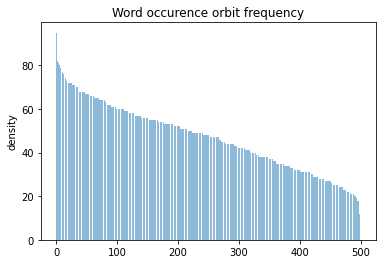

In [239]:
from faker import Faker
fake = Faker()

states = [fake.name() for _ in range(500)]
T = TransitionMatrix.uniform_bidirected(states, 0.9)


people = T.p.keys()
num_friends = [len(T.p[person]) for person in people]
y_pos = np.arange(len(people))
num_friends.sort(reverse = True)
plt.bar(y_pos, num_friends, align='center', alpha=0.5)
plt.ylabel('density')
plt.title('Word occurence orbit frequency')
plt.show()

distance from uniform:  0.014628883859997659


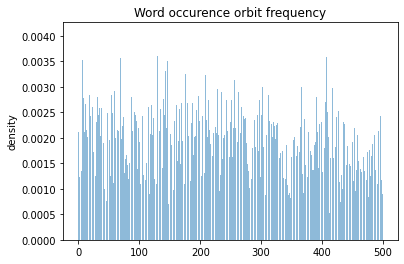

In [240]:
uniform = State.from_uniform(states)

person = random.choice(states)
orbit = [Walker(person)]

for i in range(1000000):
    orbit.append(T@orbit[-1])

orbit_dist = State.from_orbit([o.state for o in orbit])

print('distance from uniform: ', orbit_dist.dist(uniform))
orbit_dist.draw()

In [241]:
person = random.choice(states)
uniform = State.from_uniform(states)

orbit_1 = [MetropolisWalker(person)]
orbit_2 = [Walker(person)]

differences_1 = []
differences_2 = []
differences_3 = []

for i in range(10000):
    orbit_1.append(T@orbit_1[-1])
    orbit_2.append(T@orbit_2[-1])
    orbit_dist_1 = State.from_orbit([o.state for o in orbit_1])
    orbit_dist_2 = State.from_orbit([o.state for o in orbit_2])
    differences_1.append(orbit_dist_1.dist(orbit_dist_2))
    differences_2.append(orbit_dist_1.dist(uniform))
    differences_3.append(orbit_dist_2.dist(uniform))


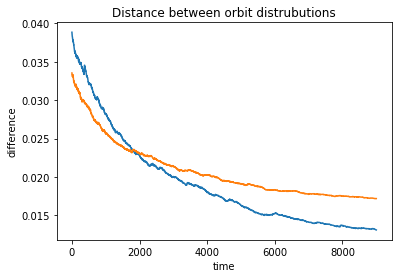

Normal walker: 0.021432408305679558
Metropolis walker: 0.0130918180229567


In [242]:
# plt.plot(differences_1[:])
plt.plot(differences_2[1000:]) # metropolis walker
plt.plot(differences_3[1000:]) # normal walker
plt.title('Distance between orbit distrubutions')
plt.ylabel('difference')
plt.xlabel('time')
plt.show()

print('Normal walker: {}'.format(differences_1[-1]))
print('Metropolis walker: {}'.format(differences_2[-1]))

distance from uniform:  0.0007838692713636189


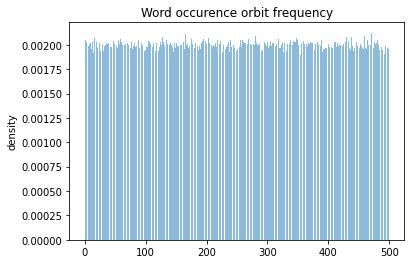

In [243]:
person = random.choice(states)

orbit = [MetropolisWalker(person)]

for i in range(3000000):
    orbit.append(T@orbit[-1])

orbit_dist = State.from_orbit([o.state for o in orbit])

print('distance from uniform: ', orbit_dist.dist(uniform))
orbit_dist.draw()